<a href="https://colab.research.google.com/github/maleahjamieson/machine_learning/blob/master/HW_4/HW4_convnet_finetuning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning ResNet101 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the ResNet101 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [23]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 23:45:32--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.112, 2607:f8b0:4007:804::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   321MB/s    in 0.2s    

2020-04-21 23:45:32 (321 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with ResNet101 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import ResNet101

conv_base = ResNet101(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 5, 5, 2048)        42658176  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 55,831,681
Trainable params: 13,173,505
Non-trainable params: 42,658,176
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [30]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 32s 315ms/step - loss: 0.3771 - acc: 0.8280 - val_loss: 0.8102 - val_acc: 0.5000
Epoch 2/10
100/100 [==============================] - 25s 246ms/step - loss: 0.2712 - acc: 0.8855 - val_loss: 0.9669 - val_acc: 0.5000
Epoch 3/10
100/100 [==============================] - 25s 247ms/step - loss: 0.2564 - acc: 0.8960 - val_loss: 0.7458 - val_acc: 0.5000
Epoch 4/10
100/100 [==============================] - 25s 246ms/step - loss: 0.2295 - acc: 0.9120 - val_loss: 0.9683 - val_acc: 0.5000
Epoch 5/10
100/100 [==============================] - 25s 246ms/step - loss: 0.2137 - acc: 0.9180 - val_loss: 0.9453 - val_acc: 0.5000
Epoch 6/10
100/100 [==============================] - 25s 250ms/step - loss: 0.2051 - acc: 0.9160 - val_loss: 0.8855 - val_acc: 0.5000
Epoch 7/10
100/100 [==============================] - 25s 246ms/step - loss: 0.2034 - acc: 0.9195 - val_lo

## Display curves of loss and accuracy during training

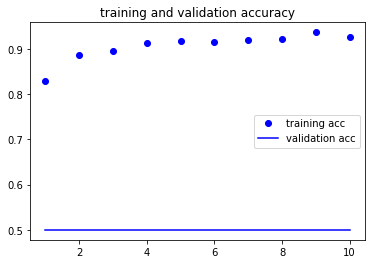

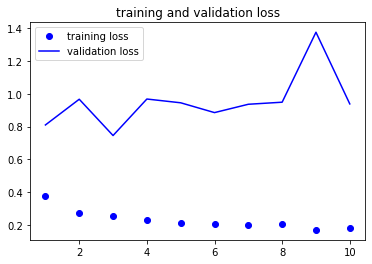

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [33]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 34s 337ms/step - loss: 0.1492 - acc: 0.9430 - val_loss: 4.6056 - val_acc: 0.5050
Epoch 2/10
100/100 [==============================] - 25s 254ms/step - loss: 0.1680 - acc: 0.9385 - val_loss: 9.5603 - val_acc: 0.5000
Epoch 3/10
100/100 [==============================] - 26s 255ms/step - loss: 0.1416 - acc: 0.9430 - val_loss: 20.1412 - val_acc: 0.5010
Epoch 4/10
100/100 [==============================] - 25s 254ms/step - loss: 0.1479 - acc: 0.9435 - val_loss: 23.7348 - val_acc: 0.5000
Epoch 5/10
100/100 [==============================] - 26s 256ms/step - loss: 0.1639 - acc: 0.9350 - val_loss: 12.9189 - val_acc: 0.4810
Epoch 6/10
100/100 [==============================] - 25s 253ms/step - loss: 0.1194 - acc: 0.9480 - val_loss: 23.1322 - val_acc: 0.5070
Epoch 7/10
100/100 [==============================] - 25s 254ms/step - loss: 0.1489 - acc: 0.9400 - val_loss: 8.5907 - val_acc: 0.5630
Epoch 8/10
100/100 [==============================]

## Display learning curves during fine-tuning

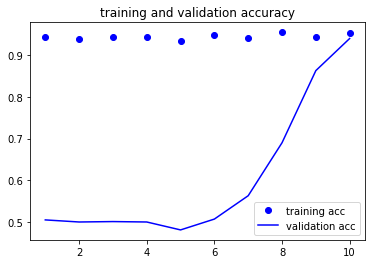

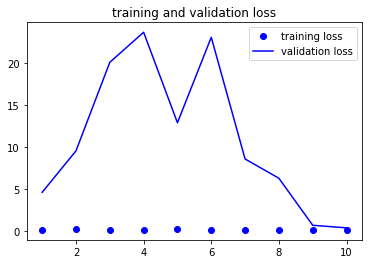

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [36]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.0665019154548645
Validation accuracy: 0.9399999976158142


I changed the number of epochs to 10 because it was taking too long to run and timing out for me

I removed the VGG16 and made it ResNet101 conv base instead.

I unfroze block 5

I added the second relu layer

Accuracy and loss was kind of super bad